In [1]:
#This notebook is to assess and compare existing methods for receipt OCR to construct a new process better suited to my specific problem. 
#It may use existing datasets and techniqus for comparison

Notes

Usually pytesseract is effective only for high resolution images. 
Certain morphological operations such as dilation, erosion, OTSU binarization can help increase in pytesseract performance.

In [2]:
#Imports
import re
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable

In [3]:
#Initialise Methods

#Resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#Display grey scale image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

#Display RGB colour image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#We will use approxPolyDP for approximating more primitive contour shape consisting of as few points as possible
#Approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

#Find 4 points of receipt
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
        
#Convert 4 points into lines / rect      
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

#Original receipt with wrapped perspective
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

#Threshold image
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

# Original Input Receipt

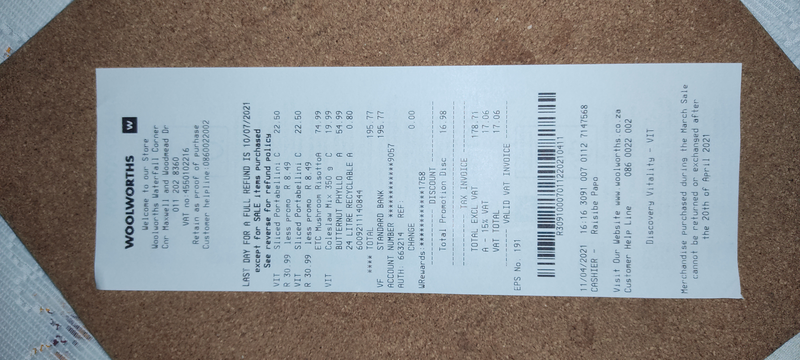

In [4]:
# Sample file out of the dataset
#dummy 01 : image on white background
#dummy 02 : image on gradient backgound
#dummy 03 : random reciept
#dummy 04 : random reciept
#Hits 02 and 09
file_name = '/kaggle/input/diveroreceiptdataset/dummy02.jpg'

img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

# Step 1: Receipt Contour Detection
In order to find receipt contour, standart edge detection preprocessing is applied:

    1.1. Convert image to grayscale
    1.2. Apply Gaussian filter 5x5 to get rid of noise
    1.3. Run Canny edge detector


In [5]:
image = cv2.imread(file_name)

#Downscale image.
#Finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

# 1.1. Convert image to grayscale

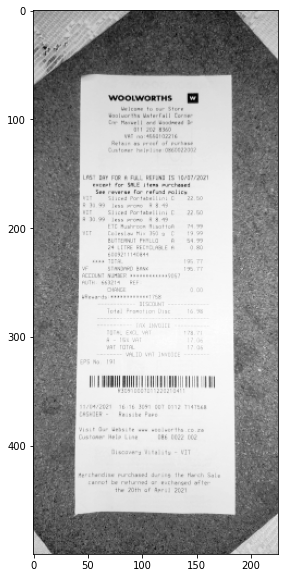

In [6]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

# 1.2. Get rid of noise with Gaussian Blur filter

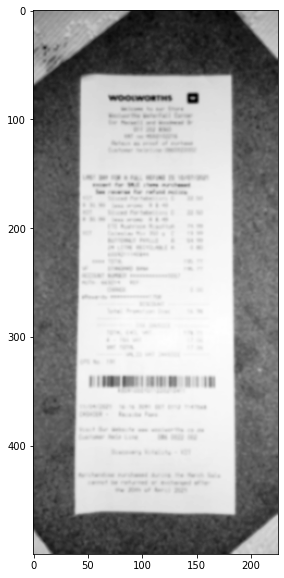

In [7]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

# Apply Dilation to Detect Regions

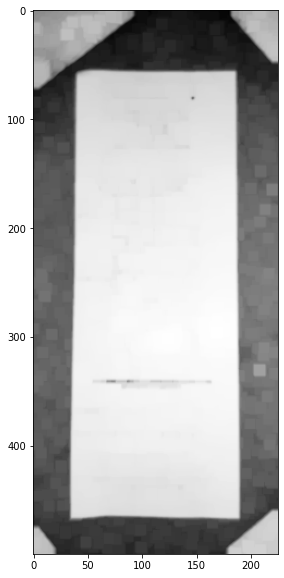

In [8]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

> If on a white backgroud then contours cannot be detected correctly

# Apply Canny Edge Detection

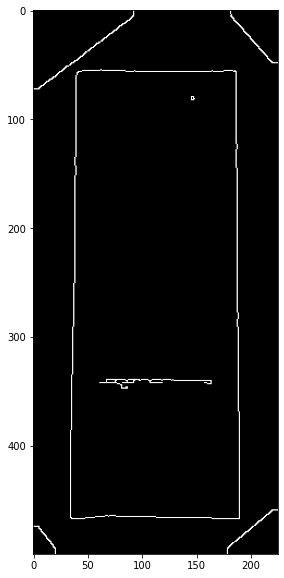

In [9]:
edged = cv2.Canny(dilated, 50, 125, apertureSize=3)
plot_gray(edged)

# Detect all contours in Canny-edged image


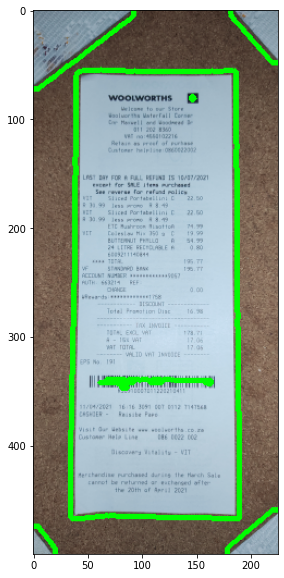

In [10]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

To find the contour of receipt we use of two heuristics / conditions:

    receipt is the largest contour whithin image
    receipt is expected to be of a rectangular shape

We will start with the first heuristic by getting TOP 1 largest contours.


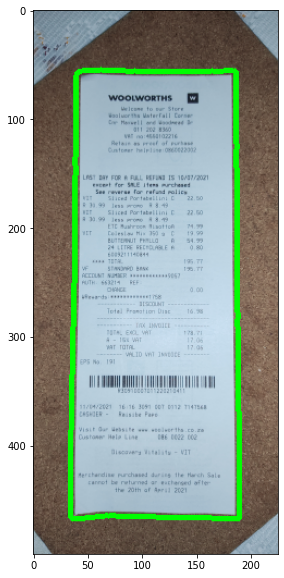

In [11]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

Vertices have been detected at a pixel level

In [12]:
get_receipt_contour(largest_contours)

array([[[ 41,  56]],

       [[ 34, 466]],

       [[189, 467]],

       [[186,  56]]], dtype=int32)

> It is also important to get down to just four contour points, as we will need them for perspective restoration

In [13]:
receipt_contour = get_receipt_contour(largest_contours)

# Display the Image with Overlayed Contour

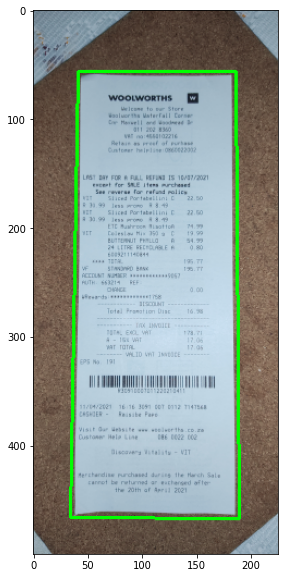

In [14]:
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

# Cropping and perspective restoration

We will make use of cv2.warpPerspective to restore perspective of the receipt.

    convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left
    use rectangle points to calculate destination points of the "scanned" view
    feed destination points into cv2.getPerspectiveTransform to calculate transformation matrix
    and finally use cv2.warpPerspective to restore the perspective!



# Display wrapped perspecive of receipt

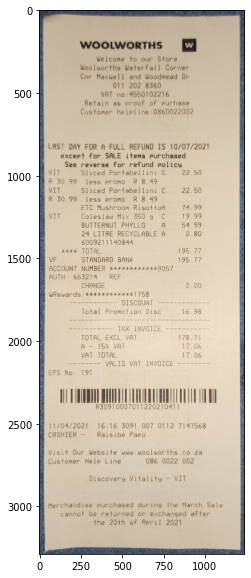

In [15]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

This images still has a lot of light and shading which could affect the OCR model

# Threshold prepare image for OCR

This mimics a scanned image. Attempts to increase OCR detection

# Computer Vision: Image Pre-Processing Model Output

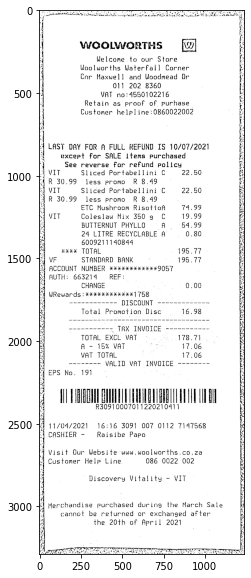

In [16]:
result = bw_scanner(scanned)
plot_gray(result)

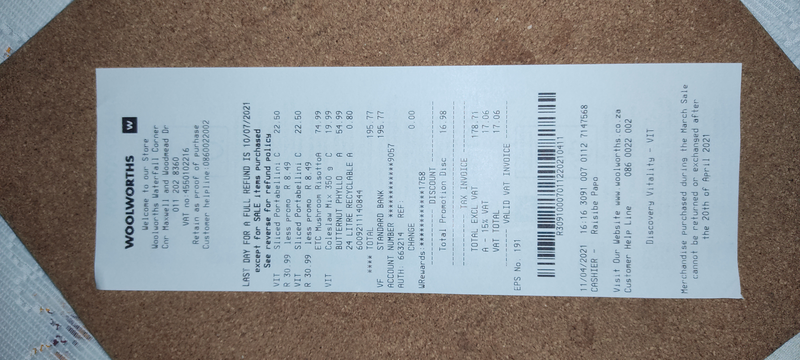

In [17]:
file_name = '/kaggle/input/diveroreceiptdataset/dummy02.jpg'

img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img


In [18]:
#Save image locally
output = Image.fromarray(result)
output.save('result.png')

## OCR MODEL

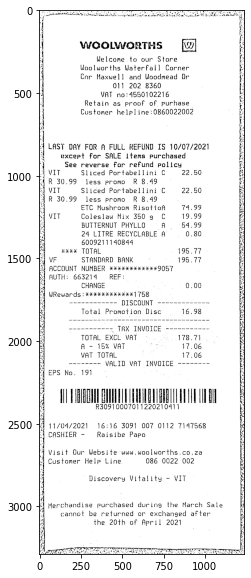

In [19]:
img
file_name = "result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

# Text box detection

Bounding box looks for dictionaty words

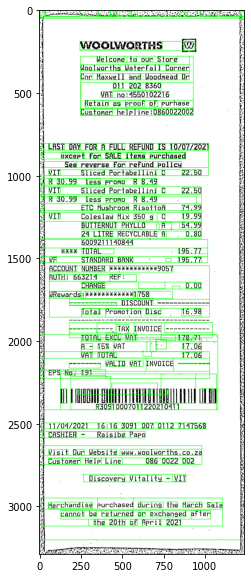

In [20]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)

n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

# Text recognition

In [21]:
custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(image, config=custom_config)
print(extracted_text)

po he EU CANCE ATEN ti Sa
wootworTHs = [@] ;
; Welcome.to our Store e
Woolworths Waterfall Corner ¥
3 Cnr Maxwell and Woodmead Dr .
* 011 202 8360 . t
- VAT no:4550102216 t
5 Retain as proof of. purhase FE
| Customer helpline :0860022002 mn
LAST DAY FOR A FULL REFUND IS 10/07/2021 3
% except for SALE items purchased fe
q See reverse for refund policy ic
“| VIT Sliced Portabellini C 22.50 fe
<4 R 30.99 less promo R 8.49 © E
“] VIT Sliced Portabellini C 22,50 S
QR 30.99 less promo R 8.49 if
: ETC Mushroom RisottoA 74,99 Z
s VIT Coleslaw Mix 350g C 19.99 is
Ss BUTTERNUT PHYLLO =A °54.99 ie
- 24 LITRE RECYCLABLE A . 0.80 2
4 6009211140844
3 xxxx TOTAL. - 195.77 °- ¢
2] VF STANDARD BANK -  -~ 198.77 be
AY ACCOUNT NUMBER ¥%%%x%xxx%x%x9057 a, S
sq AUTH: 663214 REF: ES
S CHANGE oo 0,00 bE:
24 WRewards : ¥X¥Xxxxxxxx*] 758 7 3
~~-----~-~-- DISCOUNT --------+---- 5
f Total Promotion Disc = 16.98 ss
ew wane nen nee eee s;
fo ceneecesnon TAX INVOICE c--------- s
2 — TOTAL EXCL VAT = 0 198.71 u.
x A

# Applying Regular Expressions and String handling to clean up raw data 

In [22]:
#Lines to excluse on the receipt
exclusion_list = ["bank", "total", "promo", "vat", "change", "recyclable"]

#Words to ommit
remove_list = ["vit", "etc"]

In [23]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

['“| VIT Sliced Portabellini C 22.50 fe', '<4 R 30.99 less promo R 8.49 © E', '“] VIT Sliced Portabellini C 22,50 S', 'QR 30.99 less promo R 8.49 if', ': ETC Mushroom RisottoA 74,99 Z', 's VIT Coleslaw Mix 350g C 19.99 is', 'Ss BUTTERNUT PHYLLO =A °54.99 ie', '- 24 LITRE RECYCLABLE A . 0.80 2', '3 xxxx TOTAL. - 195.77 °- ¢', '2] VF STANDARD BANK -  -~ 198.77 be', 'S CHANGE oo 0,00 bE:', 'f Total Promotion Disc = 16.98 ss', '2 — TOTAL EXCL VAT = 0 198.71 u.', 'x A- 15% VAT = "5. 47,06 | >', 'fi VAT TOTAL mo 17.06']


In [24]:
#Apply exclusion list
food_item = []
for eachLine in regex_line:
    found = False
    for exclude in exclusion_list:
        if exclude in eachLine.lower():
            found = True
        
    if found == False:
        food_item.append(eachLine)
print(food_item)

['“| VIT Sliced Portabellini C 22.50 fe', '“] VIT Sliced Portabellini C 22,50 S', ': ETC Mushroom RisottoA 74,99 Z', 's VIT Coleslaw Mix 350g C 19.99 is', 'Ss BUTTERNUT PHYLLO =A °54.99 ie']


In [25]:
#Word ommit
new_food_item_list = []
for item in food_item:
    for subToRemove in remove_list:
        item = item.replace(subToRemove, "")
        item = item.replace(subToRemove.upper(), "")
    new_food_item_list.append(item)
print(new_food_item_list)

['“|  Sliced Portabellini C 22.50 fe', '“]  Sliced Portabellini C 22,50 S', ':  Mushroom RisottoA 74,99 Z', 's  Coleslaw Mix 350g C 19.99 is', 'Ss BUTTERNUT PHYLLO =A °54.99 ie']


In [26]:
#Food item cost regex
food_item_cost = []
for line in new_food_item_list:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+|\d*\,?\d+|',line)
    
    for possibleCost in cost:
        if "." in possibleCost:
            food_item_cost.append(possibleCost)
print(new_food_item_list)


['“|  Sliced Portabellini C 22.50 fe', '“]  Sliced Portabellini C 22,50 S', ':  Mushroom RisottoA 74,99 Z', 's  Coleslaw Mix 350g C 19.99 is', 'Ss BUTTERNUT PHYLLO =A °54.99 ie']


In [27]:
#Remove cost price from food item
count = 0;
only_food_items = []
for item in new_food_item_list:
    only_alpha = ""
    for char in item:
        if char.isalpha() or char.isspace():
            only_alpha += char
            
    only_alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', only_alpha).strip()
    only_food_items.append(only_alpha)
print(only_food_items)

['Sliced Portabellini  fe', 'Sliced Portabellini', 'Mushroom RisottoA', 'Coleslaw Mix C  is', 'Ss BUTTERNUT PHYLLO  ie']


In [28]:
#Removes 2 letter words from food item
#No core food item has two letters (Most cases)
food = []
for item in only_food_items:
    # getting splits
    temp = item.split()

    # omitting K lengths
    res = [ele for ele in temp if len(ele) != 2]

    # joining result
    res = ' '.join(res)
    
    food.append(res)
print(food)

['Sliced Portabellini', 'Sliced Portabellini', 'Mushroom RisottoA', 'Coleslaw Mix C', 'BUTTERNUT PHYLLO']


# Optical Character Recognition Model Output

In [29]:
#Taulate Food Item and Cost
t = PrettyTable(['Food Item', 'Cost'])
for counter in range (0,len(food)):
    t.add_row([food[counter], food_item_cost[counter]])
print(t)

+---------------------+-------+
|      Food Item      |  Cost |
+---------------------+-------+
| Sliced Portabellini | 22.50 |
| Sliced Portabellini | 22.50 |
|  Mushroom RisottoA  | 74.99 |
|    Coleslaw Mix C   | 19.99 |
|   BUTTERNUT PHYLLO  | 54.99 |
+---------------------+-------+
